# Data & Imports

In [8]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [9]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
# path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'
path = 'C:/Users/Monte/Documents/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [11]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [12]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [3,5,7,9],)
conv_num_layers = hp.Choice("conv_layers", [1,2,3,4,5],)
conv_num_blocks = hp.Choice("conv_blocks", [1,2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256,512],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [1,2,3])
dense_units = hp.Choice("dense_units", [32,64,128,256,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=100,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,)

model = generateAutoModel()


Reloading Tuner from .\auto_model\tuner0.json


In [13]:
# set timer
curr_time = time.time()

In [14]:
# 6 hrs, 15 min 100 modelos
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)



Epoch 1/20
459/459 [==============================] - 18s 29ms/step - loss: 0.1009 - mae: 0.2562 - val_loss: 0.0518 - val_mae: 0.1728
Epoch 2/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0496 - mae: 0.1706 - val_loss: 0.0375 - val_mae: 0.1400
Epoch 3/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0314 - mae: 0.1288 - val_loss: 0.0214 - val_mae: 0.1017
Epoch 4/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0217 - mae: 0.1048 - val_loss: 0.0163 - val_mae: 0.0839
Epoch 5/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0190 - mae: 0.0973 - val_loss: 0.0133 - val_mae: 0.0776
Epoch 6/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0178 - mae: 0.0939 - val_loss: 0.0125 - val_mae: 0.0750
Epoch 7/20
459/459 [==============================] - 12s 26ms/step - loss: 0.0158 - mae: 0.0879 - val_loss: 0.0115 - val_mae: 0.0730
Epoch 8/20
459/459 [==============================] - 12s 26ms

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [15]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 4 minutes, 9.490367 seconds  ---


In [16]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 133, 32)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 127, 512)          115200    
                                                                 
 conv1d_2 (Conv1D)           (None, 121, 32)           114720    
                                                                 
 conv1d_3 (Conv1D)           (None, 115, 256)          57600     
                                                             

In [17]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 2s 10ms/step - loss: 0.0066 - mae: 0.0492
loss: 0.007  MAE:0.049


In [18]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_test))

153/153 [==============================] - 1s 7ms/step


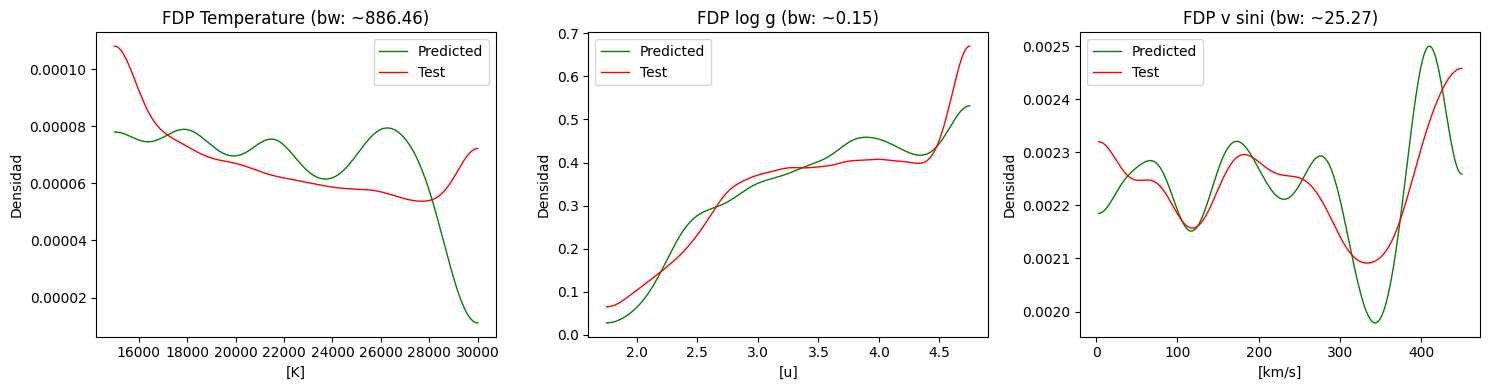

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

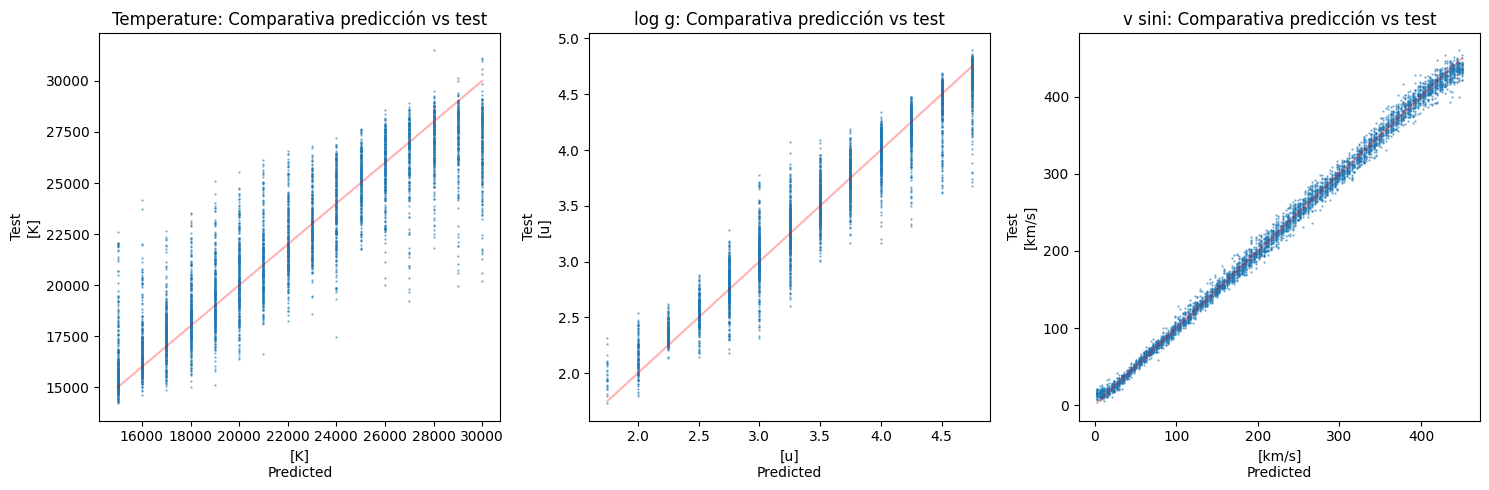

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


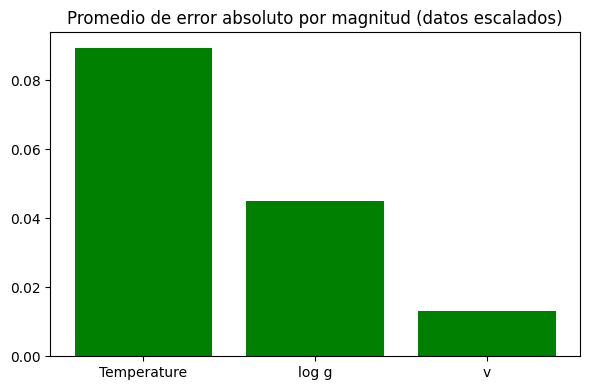

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (modelo único)

In [22]:
#predicciones de modelo unico
predictions = y_scaler.inverse_transform(model.predict(formatted_x_train))

459/459 [==============================] - 3s 7ms/step


In [23]:
#data formatting
inverse_y_train = y_scaler.inverse_transform(y_train)
rel_error = np.abs(predictions-inverse_y_train)*(1/inverse_y_train)*100
abs_error = np.abs(predictions-inverse_y_train)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_train[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_train[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_train[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [24]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(10)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,16000,15750,250 (1.6%),3.0,2.78,0 (1.0%),159,155,4 (2.6%)
1,16000,15811,189 (1.2%),3.0,2.82,0 (2.4%),324,320,4 (1.3%)
2,20000,19842,158 (0.8%),4.0,4.37,0 (2.9%),111,107,4 (3.9%)
3,24000,24687,687 (2.9%),3.0,3.6,0 (2.8%),420,419,1 (0.3%)
4,18000,20338,2338 (13.0%),4.0,3.95,0 (1.3%),216,227,11 (5.2%)
5,25000,26507,1507 (6.0%),4.0,3.77,0 (0.4%),348,339,9 (2.5%)
6,16000,15683,317 (2.0%),3.0,2.78,0 (1.3%),162,158,4 (2.5%)
7,21000,19226,1774 (8.4%),4.0,3.77,0 (0.7%),225,225,0 (0.1%)
8,19000,19170,170 (0.9%),3.0,3.09,0 (3.0%),93,91,2 (2.6%)
9,25000,23602,1398 (5.6%),3.0,2.71,0 (1.4%),219,225,6 (2.9%)


### Datos observados vs predicción de modelo único

In [25]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_obs))

3/3 [==============================] - 0s 7ms/step


In [26]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [27]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
HD,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16896,2630 (13.5%),3.0,3.33,0 (1.0%),287,283,4 (1.3%)
33328,2013-01-18,03-39-09,19526,17509,2017 (10.3%),3.0,3.47,0 (5.3%),287,288,1 (0.3%)
33328,2013-02-26,00-55-34,19526,18652,874 (4.5%),3.0,3.11,0 (5.8%),287,292,5 (1.8%)
33328,2015-02-25,23-58-07,19526,14455,5071 (26.0%),3.0,4.49,1 (36.0%),287,244,43 (14.8%)
33328,2015-02-26,00-19-03,19526,17179,2347 (12.0%),3.0,3.75,0 (13.5%),287,285,2 (0.6%)
35165,2014-03-20,23-53-54,17000,17315,315 (1.9%),4.0,3.89,0 (2.7%),240,281,41 (17.2%)
35165,2014-03-21,00-14-49,17000,18193,1193 (7.0%),4.0,3.77,0 (5.7%),240,295,55 (23.1%)
35165,2014-03-21,00-35-18,17000,18128,1128 (6.6%),4.0,3.44,1 (14.1%),240,286,46 (19.0%)
35165,2015-11-14,04-22-43,17000,22983,5983 (35.2%),4.0,3.22,1 (19.4%),240,282,42 (17.6%)


In [28]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# / TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [29]:
# set timer
curr_time = time.time()

In [30]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 50
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	keras.utils.set_random_seed(i)
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1077 - mae: 0.2650
Epoch 2/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0333 - mae: 0.1337
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0248 - mae: 0.1134
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0203 - mae: 0.1012
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0186 - mae: 0.0970
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0157 - mae: 0.0881
Epoch 7/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0153 - mae: 0.0865
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0150 - mae: 0.0853
Epoch 9/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0146 - mae: 0.0843
Epoch 10/30
459/459 [==============================] - 11s 24ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 24ms/step - loss: 0.1081 - mae: 0.2697
Epoch 2/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0541 - mae: 0.1812
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0455 - mae: 0.1610
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0324 - mae: 0.1314
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0213 - mae: 0.1041
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0186 - mae: 0.0964
Epoch 7/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0171 - mae: 0.0918
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0163 - mae: 0.0898
Epoch 9/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0158 - mae: 0.0875
Epoch 10/30
459/459 [==============================] - 11s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1020 - mae: 0.2576
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0456 - mae: 0.1620
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0283 - mae: 0.1218
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0218 - mae: 0.1053
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0194 - mae: 0.0984
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0175 - mae: 0.0923
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0893
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0167 - mae: 0.0905
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0151 - mae: 0.0854
Epoch 10/30
459/459 [==============================] - 11s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1034 - mae: 0.2609
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0538 - mae: 0.1809
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0280 - mae: 0.1224
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0210 - mae: 0.1031
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0187 - mae: 0.0967
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0177 - mae: 0.0941
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0163 - mae: 0.0896
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0161 - mae: 0.0891
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0147 - mae: 0.0839
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1040 - mae: 0.2602
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0435 - mae: 0.1567
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0368 - mae: 0.1400
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0327 - mae: 0.1293
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0272 - mae: 0.1151
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0235 - mae: 0.1079
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0179 - mae: 0.0927
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0171 - mae: 0.0909
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0855
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1017 - mae: 0.2586
Epoch 2/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0475 - mae: 0.1656
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0637 - mae: 0.2004
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0348 - mae: 0.1379
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0212 - mae: 0.1033
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0185 - mae: 0.0955
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0181 - mae: 0.0940
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0165 - mae: 0.0892
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0870
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1032 - mae: 0.2624
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0529 - mae: 0.1783
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0298 - mae: 0.1247
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0227 - mae: 0.1073
Epoch 5/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0198 - mae: 0.0994
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0947
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0170 - mae: 0.0909
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0158 - mae: 0.0872
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0870
Epoch 10/30
459/459 [==============================] - 10s 22ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1030 - mae: 0.2565
Epoch 2/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0406 - mae: 0.1499
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0291 - mae: 0.1227
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0224 - mae: 0.1065
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0190 - mae: 0.0972
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0172 - mae: 0.0917
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0165 - mae: 0.0901
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0856
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0148 - mae: 0.0841
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1045 - mae: 0.2608
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0468 - mae: 0.1649
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0285 - mae: 0.1231
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0205 - mae: 0.1020
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0194 - mae: 0.0992
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0181 - mae: 0.0954
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0171 - mae: 0.0917
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0159 - mae: 0.0883
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0863
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1107 - mae: 0.2704
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0425 - mae: 0.1556
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0258 - mae: 0.1159
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0220 - mae: 0.1065
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0188 - mae: 0.0975
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0171 - mae: 0.0925
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0159 - mae: 0.0885
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0159 - mae: 0.0882
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0142 - mae: 0.0828
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 24ms/step - loss: 0.1047 - mae: 0.2628
Epoch 2/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0536 - mae: 0.1799
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0305 - mae: 0.1272
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0223 - mae: 0.1074
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0195 - mae: 0.0993
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0183 - mae: 0.0959
Epoch 7/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0173 - mae: 0.0927
Epoch 8/30
459/459 [==============================] - 11s 24ms/step - loss: 0.0165 - mae: 0.0900
Epoch 9/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0155 - mae: 0.0871
Epoch 10/30
459/459 [==============================] - 11s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 24ms/step - loss: 0.0932 - mae: 0.2397
Epoch 2/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0409 - mae: 0.1501
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0367 - mae: 0.1403
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0317 - mae: 0.1269
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0284 - mae: 0.1183
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0245 - mae: 0.1095
Epoch 7/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0202 - mae: 0.0985
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0179 - mae: 0.0932
Epoch 9/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0173 - mae: 0.0912
Epoch 10/30
459/459 [==============================] - 11s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 24ms/step - loss: 0.0985 - mae: 0.2509
Epoch 2/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0458 - mae: 0.1618
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0390 - mae: 0.1451
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0337 - mae: 0.1315
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0295 - mae: 0.1204
Epoch 6/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0263 - mae: 0.1117
Epoch 7/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0265 - mae: 0.1126
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0220 - mae: 0.1023
Epoch 9/30
459/459 [==============================] - 11s 24ms/step - loss: 0.0193 - mae: 0.0956
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1070 - mae: 0.2659
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0463 - mae: 0.1634
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0370 - mae: 0.1407
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0267 - mae: 0.1156
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0197 - mae: 0.0988
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0949
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0166 - mae: 0.0901
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0148 - mae: 0.0845
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0148 - mae: 0.0844
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1099 - mae: 0.2732
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0624 - mae: 0.2003
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0421 - mae: 0.1550
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0242 - mae: 0.1116
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0197 - mae: 0.0996
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0953
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0168 - mae: 0.0913
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0166 - mae: 0.0906
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0150 - mae: 0.0852
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1045 - mae: 0.2623
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0406 - mae: 0.1509
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0275 - mae: 0.1201
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0209 - mae: 0.1032
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0956
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0175 - mae: 0.0934
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0897
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0156 - mae: 0.0870
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0864
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1056 - mae: 0.2628
Epoch 2/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0465 - mae: 0.1641
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0424 - mae: 0.1545
Epoch 4/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0245 - mae: 0.1119
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0197 - mae: 0.0992
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0181 - mae: 0.0950
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0162 - mae: 0.0893
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0877
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0151 - mae: 0.0864
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0973 - mae: 0.2480
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0457 - mae: 0.1608
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0353 - mae: 0.1364
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0251 - mae: 0.1125
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0200 - mae: 0.0993
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0175 - mae: 0.0931
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0169 - mae: 0.0907
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0160 - mae: 0.0879
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0150 - mae: 0.0846
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0978 - mae: 0.2463
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0441 - mae: 0.1570
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0332 - mae: 0.1323
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0230 - mae: 0.1074
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0201 - mae: 0.1003
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0173 - mae: 0.0922
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0162 - mae: 0.0889
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0160 - mae: 0.0880
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0871
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1011 - mae: 0.2532
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0482 - mae: 0.1668
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0387 - mae: 0.1443
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0279 - mae: 0.1195
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0216 - mae: 0.1040
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0181 - mae: 0.0943
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0163 - mae: 0.0890
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0151 - mae: 0.0851
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0145 - mae: 0.0830
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1015 - mae: 0.2556
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0516 - mae: 0.1749
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0426 - mae: 0.1544
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0279 - mae: 0.1212
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0205 - mae: 0.1013
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0178 - mae: 0.0940
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0169 - mae: 0.0913
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0156 - mae: 0.0870
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0874
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1039 - mae: 0.2596
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0509 - mae: 0.1722
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0412 - mae: 0.1507
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0330 - mae: 0.1314
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0256 - mae: 0.1142
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0204 - mae: 0.1002
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0943
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0169 - mae: 0.0905
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0169 - mae: 0.0905
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1032 - mae: 0.2603
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0419 - mae: 0.1529
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0258 - mae: 0.1150
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0208 - mae: 0.1022
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0181 - mae: 0.0949
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0953
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0157 - mae: 0.0869
Epoch 8/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0155 - mae: 0.0868
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0149 - mae: 0.0847
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0993 - mae: 0.2501
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0429 - mae: 0.1550
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0342 - mae: 0.1334
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0280 - mae: 0.1180
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0218 - mae: 0.1030
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0193 - mae: 0.0970
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0175 - mae: 0.0919
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0170 - mae: 0.0907
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0853
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1042 - mae: 0.2590
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0469 - mae: 0.1646
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0351 - mae: 0.1374
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0246 - mae: 0.1125
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0206 - mae: 0.1026
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0180 - mae: 0.0955
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0897
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0151 - mae: 0.0860
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0147 - mae: 0.0844
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1036 - mae: 0.2608
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0454 - mae: 0.1617
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0457 - mae: 0.1613
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0279 - mae: 0.1202
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0213 - mae: 0.1035
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0186 - mae: 0.0956
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0176 - mae: 0.0932
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0163 - mae: 0.0892
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0152 - mae: 0.0860
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 23ms/step - loss: 0.0997 - mae: 0.2532
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0416 - mae: 0.1526
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0311 - mae: 0.1277
Epoch 4/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0214 - mae: 0.1038
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0185 - mae: 0.0958
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0168 - mae: 0.0906
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0157 - mae: 0.0876
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0150 - mae: 0.0854
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0140 - mae: 0.0821
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1049 - mae: 0.2601
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0358 - mae: 0.1397
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0263 - mae: 0.1170
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0221 - mae: 0.1060
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0183 - mae: 0.0957
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0896
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0154 - mae: 0.0867
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0147 - mae: 0.0842
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0140 - mae: 0.0818
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0970 - mae: 0.2474
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0432 - mae: 0.1559
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0328 - mae: 0.1308
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0228 - mae: 0.1071
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0197 - mae: 0.0991
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0176 - mae: 0.0938
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0163 - mae: 0.0893
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0149 - mae: 0.0845
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0151 - mae: 0.0856
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0940 - mae: 0.2405
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0391 - mae: 0.1465
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0369 - mae: 0.1410
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0273 - mae: 0.1180
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0213 - mae: 0.1029
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0188 - mae: 0.0960
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0169 - mae: 0.0905
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0862
Epoch 9/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0147 - mae: 0.0838
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1019 - mae: 0.2570
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0442 - mae: 0.1580
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0475 - mae: 0.1646
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0291 - mae: 0.1217
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0211 - mae: 0.1027
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0184 - mae: 0.0955
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0170 - mae: 0.0918
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0171 - mae: 0.0913
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0145 - mae: 0.0835
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1042 - mae: 0.2623
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0439 - mae: 0.1581
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0255 - mae: 0.1152
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0210 - mae: 0.1031
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0186 - mae: 0.0959
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0168 - mae: 0.0905
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0158 - mae: 0.0874
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0162 - mae: 0.0886
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0150 - mae: 0.0849
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0987 - mae: 0.2508
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0394 - mae: 0.1475
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0437 - mae: 0.1562
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0227 - mae: 0.1067
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0186 - mae: 0.0959
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0173 - mae: 0.0922
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0161 - mae: 0.0884
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0149 - mae: 0.0846
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0140 - mae: 0.0818
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0966 - mae: 0.2490
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0498 - mae: 0.1702
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0465 - mae: 0.1625
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0350 - mae: 0.1359
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0244 - mae: 0.1112
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0210 - mae: 0.1026
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0187 - mae: 0.0963
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0177 - mae: 0.0929
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0166 - mae: 0.0900
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 23ms/step - loss: 0.1047 - mae: 0.2584
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0422 - mae: 0.1534
Epoch 3/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0293 - mae: 0.1236
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0203 - mae: 0.1009
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0187 - mae: 0.0964
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0173 - mae: 0.0926
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0175 - mae: 0.0933
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0868
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0140 - mae: 0.0819
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1061 - mae: 0.2642
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0414 - mae: 0.1528
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0258 - mae: 0.1165
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0204 - mae: 0.1017
Epoch 5/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0185 - mae: 0.0962
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0174 - mae: 0.0926
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0898
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0161 - mae: 0.0885
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0149 - mae: 0.0848
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1013 - mae: 0.2531
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0469 - mae: 0.1641
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0371 - mae: 0.1414
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0261 - mae: 0.1155
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0205 - mae: 0.1016
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0177 - mae: 0.0937
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0173 - mae: 0.0920
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0158 - mae: 0.0873
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0149 - mae: 0.0849
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1002 - mae: 0.2544
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0458 - mae: 0.1625
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0394 - mae: 0.1466
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0243 - mae: 0.1114
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0199 - mae: 0.1002
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0186 - mae: 0.0959
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0172 - mae: 0.0921
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0160 - mae: 0.0882
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0149 - mae: 0.0847
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0931 - mae: 0.2416
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0409 - mae: 0.1510
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0330 - mae: 0.1320
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0232 - mae: 0.1080
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0195 - mae: 0.0986
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0171 - mae: 0.0920
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0162 - mae: 0.0889
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0857
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0142 - mae: 0.0824
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1018 - mae: 0.2563
Epoch 2/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0537 - mae: 0.1799
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0391 - mae: 0.1467
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0258 - mae: 0.1149
Epoch 5/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0215 - mae: 0.1046
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0187 - mae: 0.0961
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0185 - mae: 0.0955
Epoch 8/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0169 - mae: 0.0907
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0854
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 16s 23ms/step - loss: 0.1042 - mae: 0.2591
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0373 - mae: 0.1429
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0294 - mae: 0.1241
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0219 - mae: 0.1055
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0200 - mae: 0.1008
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0176 - mae: 0.0929
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0165 - mae: 0.0899
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0152 - mae: 0.0857
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0856
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0956 - mae: 0.2434
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0406 - mae: 0.1496
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0339 - mae: 0.1326
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0286 - mae: 0.1192
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0242 - mae: 0.1083
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0205 - mae: 0.0993
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0180 - mae: 0.0925
Epoch 8/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0173 - mae: 0.0909
Epoch 9/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0163 - mae: 0.0883
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1048 - mae: 0.2608
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0464 - mae: 0.1628
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0298 - mae: 0.1249
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0219 - mae: 0.1053
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0191 - mae: 0.0977
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0177 - mae: 0.0935
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0163 - mae: 0.0890
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0864
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0866
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1040 - mae: 0.2630
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0523 - mae: 0.1768
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0381 - mae: 0.1442
Epoch 4/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0240 - mae: 0.1101
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0191 - mae: 0.0972
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0178 - mae: 0.0939
Epoch 7/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0165 - mae: 0.0904
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0166 - mae: 0.0902
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0864
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1007 - mae: 0.2516
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0401 - mae: 0.1482
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0295 - mae: 0.1243
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0209 - mae: 0.1023
Epoch 5/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0185 - mae: 0.0958
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0166 - mae: 0.0898
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0868
Epoch 8/30
459/459 [==============================] - 11s 23ms/step - loss: 0.0154 - mae: 0.0865
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0144 - mae: 0.0829
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1028 - mae: 0.2595
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0434 - mae: 0.1565
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0357 - mae: 0.1381
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0256 - mae: 0.1136
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0208 - mae: 0.1012
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0185 - mae: 0.0957
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0160 - mae: 0.0877
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0155 - mae: 0.0866
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0143 - mae: 0.0825
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0994 - mae: 0.2535
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0459 - mae: 0.1624
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0507 - mae: 0.1709
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0412 - mae: 0.1505
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0309 - mae: 0.1252
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0248 - mae: 0.1112
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0203 - mae: 0.1002
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0170 - mae: 0.0913
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0161 - mae: 0.0884
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.1142 - mae: 0.2737
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0441 - mae: 0.1586
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0291 - mae: 0.1242
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0210 - mae: 0.1031
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0181 - mae: 0.0951
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0169 - mae: 0.0910
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0164 - mae: 0.0899
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0154 - mae: 0.0865
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0153 - mae: 0.0860
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0943 - mae: 0.2442
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0431 - mae: 0.1557
Epoch 3/30
459/459 [==============================] - 10s 22ms/step - loss: 0.0380 - mae: 0.1429
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0320 - mae: 0.1281
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0257 - mae: 0.1129
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0204 - mae: 0.0998
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0182 - mae: 0.0941
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0170 - mae: 0.0908
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0150 - mae: 0.0850
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 15s 23ms/step - loss: 0.0966 - mae: 0.2473
Epoch 2/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0449 - mae: 0.1598
Epoch 3/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0338 - mae: 0.1331
Epoch 4/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0290 - mae: 0.1208
Epoch 5/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0232 - mae: 0.1073
Epoch 6/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0206 - mae: 0.1010
Epoch 7/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0172 - mae: 0.0913
Epoch 8/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0154 - mae: 0.0859
Epoch 9/30
459/459 [==============================] - 10s 23ms/step - loss: 0.0160 - mae: 0.0883
Epoch 10/30
459/459 [==============================] - 10s 23ms/step - loss: 0.01

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [31]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 4 hours, 31 minutes, 59.565341 seconds  ---


In [32]:
# prediccion de datos observados
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 1s 6ms/step


In [33]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 2s 9ms/step - loss: 0.0057 - mae: 0.0446


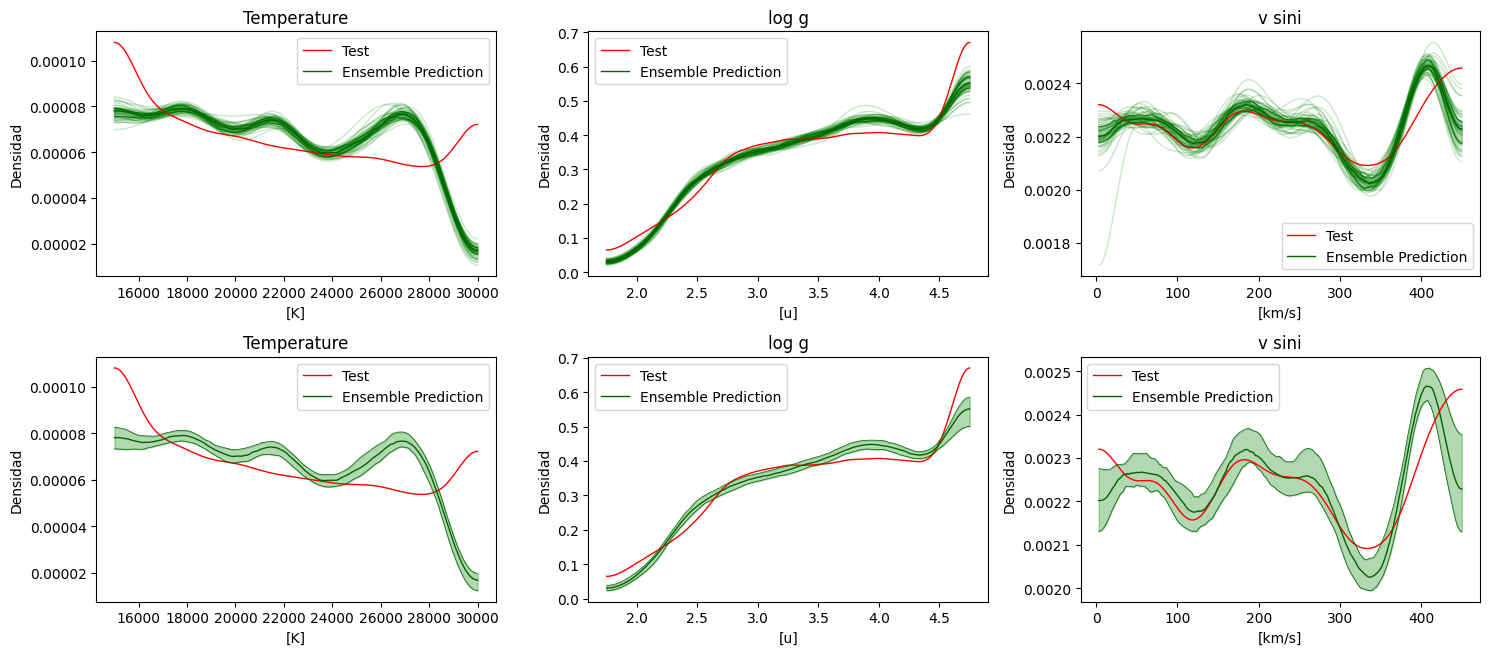

In [34]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

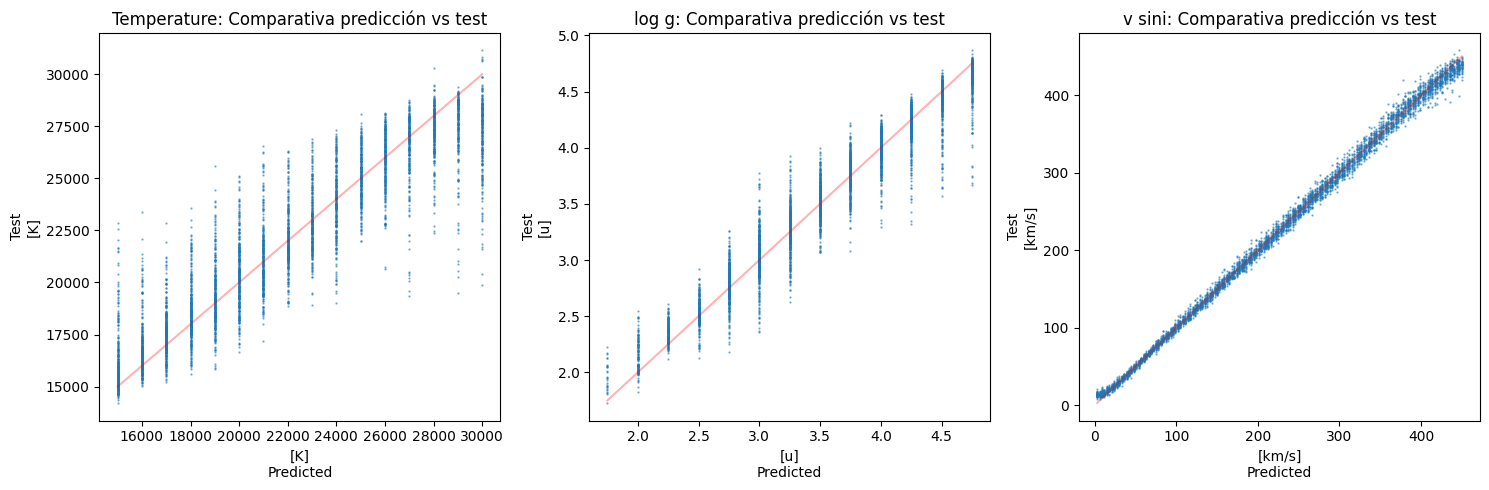

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\Documents\Memoria\py310tf210\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\monte\

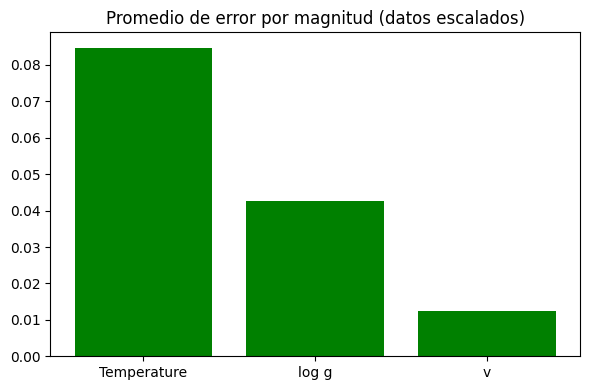

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (ensamble)

In [37]:
# / TODO Error relativo-absoluto agregado en la tabla
# / TODO scatter de valor esperado sobre prediccion
# TODO graficar comparativa entre estrella sitentica y real
# TODO grafica con vecindario de espectro real

In [38]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,17000.0,17396.453125,222.740936,3.25,3.300895,0.055099,246.0,245.776932,2.734417
1,18000.0,16608.558594,290.460144,2.75,2.741580,0.051966,285.0,284.239471,5.247086
2,30000.0,26929.228516,335.464172,3.75,3.574593,0.030993,267.0,266.190308,3.318972
3,23000.0,21329.001953,587.156982,2.50,2.441511,0.040561,63.0,62.394814,3.771440
4,19000.0,20327.480469,272.565155,3.00,3.034133,0.036525,126.0,128.448517,2.976175
5,17000.0,17169.705078,209.227066,4.50,4.336582,0.067731,156.0,160.783707,3.582121
6,28000.0,23718.666016,787.893921,3.25,2.924940,0.064166,450.0,438.514099,4.184331
7,22000.0,20672.927734,241.141983,4.00,4.068968,0.028816,285.0,287.556274,3.355545
8,23000.0,23619.970703,375.998932,3.00,3.009103,0.029814,30.0,30.004635,2.060352
9,23000.0,22066.294922,246.346329,4.50,4.486877,0.030110,153.0,152.827698,5.012657


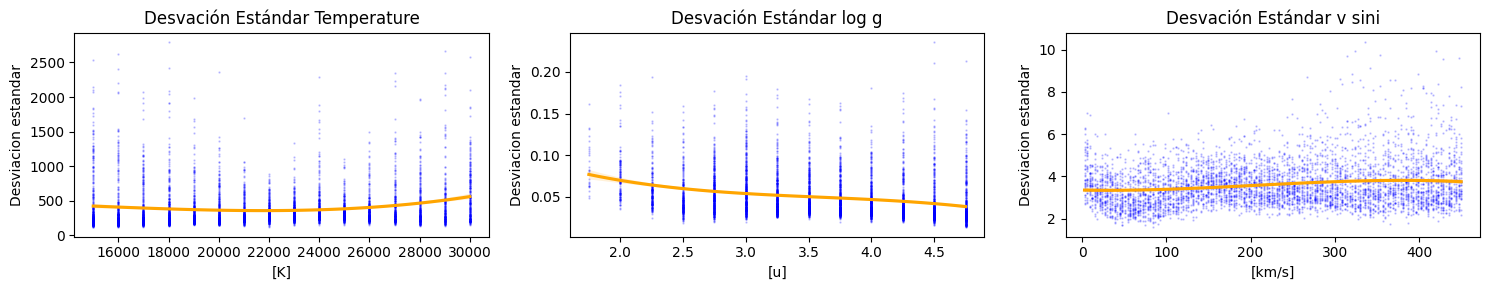

In [39]:
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temp', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [40]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

3/3 [==============================] - 0s 31ms/step


In [41]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],0)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [42]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
HD,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16989 ± 350,2537.0 (13.0%),3.0,3.31 ± 0.08,0.01 (0.3%),287,282 ± 6,5.0 (1.8%)
33328,2013-01-18,03-39-09,19526,15810 ± 668,3716.0 (19.0%),3.0,3.9 ± 0.22,0.6 (18.3%),287,282 ± 7,5.0 (1.8%)
33328,2013-02-26,00-55-34,19526,18982 ± 402,544.0 (2.8%),3.0,3.06 ± 0.06,0.24 (7.2%),287,301 ± 6,14.0 (4.8%)
33328,2015-02-25,23-58-07,19526,16493 ± 1584,3033.0 (15.5%),3.0,4.09 ± 0.35,0.79 (23.9%),287,272 ± 24,15.0 (5.1%)
33328,2015-02-26,00-19-03,19526,17294 ± 765,2232.0 (11.4%),3.0,3.68 ± 0.23,0.38 (11.6%),287,287 ± 14,0.0 (0.1%)
35165,2014-03-20,23-53-54,17000,17614 ± 826,614.0 (3.6%),4.0,3.81 ± 0.31,0.19 (4.7%),240,276 ± 17,36.0 (15.0%)
35165,2014-03-21,00-14-49,17000,18843 ± 610,1843.0 (10.8%),4.0,3.72 ± 0.18,0.28 (6.9%),240,297 ± 12,57.0 (23.6%)
35165,2014-03-21,00-35-18,17000,17894 ± 842,894.0 (5.3%),4.0,3.53 ± 0.22,0.47 (11.8%),240,286 ± 11,46.0 (19.0%)
35165,2015-11-14,04-22-43,17000,22694 ± 1051,5694.0 (33.5%),4.0,3.39 ± 0.2,0.61 (15.3%),240,307 ± 16,67.0 (28.1%)


In [43]:
# total execution time print
execution_time = float(time.time() - start_time)
print_time(execution_time)

--- Total: 4 hours, 41 minutes, 30.624490 seconds  ---
